In [1]:
import sys
sys.path.append("..") # modules folder is outside the 'tinker' folder

from modules.preprocessing import *
from modules.classification import *
from modules.maintenence import *
from pynput import keyboard
import pandas as pd
import numpy as np

from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds, BrainFlowPresets
from brainflow.data_filter import DataFilter, FilterTypes, AggOperations, NoiseTypes
from brainflow.ml_model import MLModel, BrainFlowMetrics, BrainFlowClassifiers, BrainFlowModelParams


In [3]:
import sys
sys.path.append("..")
import time
from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds, BrainFlowPresets
from modules.stream_data import *
from modules.canonical_corr import *
import numpy as np
from mvlearn.embed import CCA
import matplotlib.pyplot as plt

### Collect Sample Data For Testing

In [12]:
import time
board_id = -1  # Replace with your board ID
serial_port = "COM3"  # Replace with your serial port

brain_board = BrainFlowBoardSetup(board_id, serial_port)
# brain_board.show_params()
brain_board.setup()

sfreq = BoardShim.get_sampling_rate(board_id)
times = np.arange(data.shape[1]) / sfreq
ssvep_freq = 9.25  # 15 Hz SSVEP
ssvep_signal = np.sin(2 * np.pi * ssvep_freq * times)

time.sleep(5)
data = brain_board.get_current_board_data(1000)
# Inject SSVEP into all EEG channels
eeg_channels = BoardShim.get_eeg_channels(board_id)
for channel in eeg_channels:
    data[channel] += ssvep_signal

brain_board.stop()
# print(data.shape)

Board setup and streaming started successfully

Streaming stopped
Session released


In [4]:
data = np.load('sim_ssvep_data.npy')
data.shape

(8, 15000)

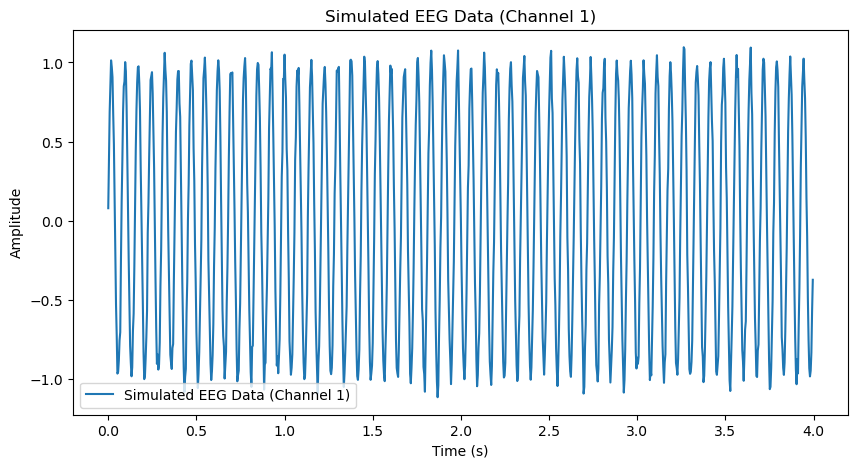

Detected frequency: 13.25 Hz with correlation: 0.9976287359172813


In [8]:
# Define parameters
frequencies = [9.25, 11.25, 13.25, 15.25]
harmonics = np.arange(1, 4)
sampling_rate = 250
n_samples = 1000  # Example number of samples per segment

# Initialize the SSVEPHarmonics class
ssvep_harmonics = ClassifySSVEP(frequencies, harmonics, sampling_rate, n_samples)

# Generate example EEG data (32 channels, 1000 samples)
time = np.linspace(0, n_samples / sampling_rate, n_samples, endpoint=False)
# eeg_data = np.sin(2 * np.pi * frequencies[0] * time) + 0.5 * np.random.randn(32, n_samples)

eeg_data = data[:, 6000:7000]

# Perform CCA analysis
detected_freq, correlation = ssvep_harmonics.cca_analysis(eeg_data)

# Plot the simulated EEG data for one channel
plt.figure(figsize=(10, 5))
plt.plot(time, eeg_data[0, :], label='Simulated EEG Data (Channel 1)')
plt.title('Simulated EEG Data (Channel 1)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

print(f"Detected frequency: {detected_freq} Hz with correlation: {correlation}")

### Testing of Vishal's Code

In [7]:
import numpy as np
import pandas as pd
from pylsl import StreamInlet, resolve_stream
from mvlearn.embed import CCA

numberpad_string =\
'''
-------
|7 8 9|
|4 5 6|
|1 2 3|
|* 0 #|
-------
'''

character_classes = ['0','1','2','3','4','5','6','7','8','9','*','#']

Fs = 256; # Sampling Rate
channel_to_label = ["G2", "G4", "F32", "G8", "G12", "G5", "G7", "G9"]
target_to_freq = [9.25, 11.25, 13.25, 9.75, 11.75, 13.75, 10.25, 12.25, 14.25, 10.75, 12.75, 14.75]
Ns = 1025 # Number samples

# data_csv = pd.read_csv('Subject1_AllTrials.csv')
# marker_indices = data_csv[data_csv['Marker']>0]
# marker_times = marker_indices['Time']

## Make 1st, 2nd, & 3rd Harmonics list
harmonics = np.arange(1,4)
Yn_list = []

for freq_idx in range(len(target_to_freq)):
    Yn = None
    freq = target_to_freq[int(freq_idx)]
    time_tmp = np.linspace(1/Fs, Ns/Fs, Ns)

    for harmon in harmonics:
        if Yn is None:
            Yn = np.vstack((np.sin(2*np.pi*harmon*freq*time_tmp), np.cos(2*np.pi*harmon*freq*time_tmp)))
        else:
            Yn = np.vstack((Yn, np.sin(2*np.pi*harmon*freq*time_tmp), np.cos(2*np.pi*harmon*freq*time_tmp)))
    Yn_list.append(Yn)

#### Sample Filter
- Butterworth filters offer a smooth frequency response without ripples.
- Chebyshev Type I filters provide a steeper roll-off with some passband ripple.
- Bessel filters maintain a linear phase response, preserving the shape of time-domain signals.
- Zero Phase versions of these filters (Butterworth, Chebyshev Type I, and Bessel) eliminate phase distortion by applying the filter in both forward and reverse directions.

In [42]:
sampling_rate = BoardShim.get_sampling_rate(board_id)  # Replace with your actual sampling rate
low_cutoff = 5.0  # Low cutoff frequency in Hz
high_cutoff = 30.0  # High cutoff frequency in Hz
order = 4  # Order of the filter

# Apply Butterworth zero phase filter to each EEG channel
for channel in range(data.shape[0]):  
    DataFilter.perform_bandpass(data[channel], sampling_rate, low_cutoff, high_cutoff, order, FilterTypes.BUTTERWORTH_ZERO_PHASE.value, 0)

#### Sample Create Fig

In [43]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

df = pd.DataFrame(np.transpose(data))
plt.figure()
df[eeg_channels].plot(subplots=True)
plt.savefig('before_processing1.png')
# plt.show()

In [16]:
df

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.0,11.856679,28.166371,50.547538,80.627063,89.188882,141.017523,351.193912,334.607843,438.420492,...,0.913090,0.953487,515.322170,260292.799187,36.594527,945.270298,1027.380089,80.118838,1.720207e+09,0.0
1,1.0,13.473383,34.069934,63.796879,89.696867,125.604539,144.834353,337.704045,337.925474,290.124289,...,0.969572,1.001005,501.679618,266969.726715,36.600997,914.054180,931.425314,89.394190,1.720207e+09,0.0
2,2.0,15.227073,40.945901,75.845455,106.498223,97.309471,124.174884,84.344944,49.084508,-11.934427,...,0.808904,1.023201,548.104170,233490.323148,36.607401,1015.100436,1037.668085,80.875009,1.720207e+09,0.0
3,3.0,16.782073,45.166965,76.455035,84.298460,74.563434,48.729067,-4.940080,-36.041321,-10.821077,...,0.985850,0.923833,480.927928,237378.027927,36.608801,939.386983,930.111965,84.748292,1.720207e+09,0.0
4,4.0,18.006525,44.797517,65.941623,69.319917,35.449800,-14.153915,-7.189757,-21.053301,72.488141,...,0.952608,1.003086,506.158874,232552.384689,36.597814,1078.965556,919.984067,80.535933,1.720207e+09,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1243,219.0,0.072074,-7.544625,-10.056208,25.974096,83.858193,154.974600,163.521672,142.939298,79.233825,...,0.853921,1.074209,546.353659,251267.823434,36.604261,996.016864,1054.429355,81.754349,1.720207e+09,0.0
1244,220.0,1.893833,-7.570214,-15.120184,1.739775,35.944451,87.593795,174.654725,236.609230,226.658471,...,0.939694,1.087181,511.756635,265838.075077,36.598865,1003.129981,1068.196881,86.002917,1.720207e+09,0.0
1245,221.0,3.485680,-1.979309,-13.973252,-19.802843,5.158895,31.953773,79.348981,125.791451,237.745997,...,0.997991,1.093316,461.635724,262895.257870,36.598919,1069.468015,979.387888,86.413602,1.720207e+09,0.0
1246,222.0,4.572715,3.330180,-1.667214,-5.658146,-13.904036,-30.228932,20.725336,22.486677,70.281724,...,0.902130,0.927415,527.011156,271505.451196,36.590694,1006.057450,1030.946219,92.330046,1.720207e+09,0.0


In [13]:
eeg_data = data
column_names = [f'Sample_{i}' for i in range(eeg_data.shape[1])]

# Create a list of row names (e.g., EEG channel names)
row_names = [f'EEG_Channel_{i+1}' for i in range(eeg_data.shape[0])]

# Convert the numpy array to a pandas DataFrame
df_eeg = pd.DataFrame(eeg_data, index=row_names, columns=column_names)

# Display the DataFrame
print(df_eeg)

                    Sample_0      Sample_1      Sample_2      Sample_3  \
EEG_Channel_1   0.000000e+00  1.000000e+00  2.000000e+00  3.000000e+00   
EEG_Channel_2   1.182338e+01  1.336513e+01  1.506229e+01  1.696428e+01   
EEG_Channel_3   2.874182e+01  3.443686e+01  4.065127e+01  4.297174e+01   
EEG_Channel_4   4.843932e+01  6.410666e+01  7.222337e+01  7.346609e+01   
EEG_Channel_5   7.013035e+01  9.538168e+01  1.053778e+02  8.063753e+01   
EEG_Channel_6   9.934015e+01  1.248878e+02  1.059063e+02  8.318827e+01   
EEG_Channel_7   1.192324e+02  1.333573e+02  1.226183e+02  4.684594e+01   
EEG_Channel_8   3.114824e+02  2.993295e+02  9.433710e+01 -1.301666e+01   
EEG_Channel_9   3.988425e+02  2.983061e+02  5.382979e+01  3.221771e+00   
EEG_Channel_10  5.167278e+02  3.117498e+02  2.681391e+01 -4.165416e+01   
EEG_Channel_11  3.754632e+02  2.604148e+02 -2.403907e+01 -5.201781e+01   
EEG_Channel_12  4.255620e+02  1.868508e+02 -3.223169e+01  5.211049e+01   
EEG_Channel_13  5.566978e+02  1.351526